In [29]:
#Imports
import matplotlib.pyplot as plt
import pandas as pd
import os

from helpers import (
    get_hurricane_bin_midpoint_times,
    get_hurricane_bin_start_times,
    get_hurricane_bin_end_times
)

In [38]:
all_hurricanes = pd.read_csv("data/global/hurricane/atl_hurricane_list_20210101_20231231.csv")

hurricane_name = "IAN"
specific_hurricane = all_hurricanes[all_hurricanes['name'] == hurricane_name]
hurricane_code = specific_hurricane['code'].values[0]
hurricane_year = specific_hurricane['year'].values[0]

glm_df = pd.read_csv(f"data/storms/{hurricane_name}_{hurricane_year}/glm/groups.csv", parse_dates=['Group Time'])
best_track_df = pd.read_csv(f'data/storms/{hurricane_name}_{hurricane_year}/hurricane/besttrack.csv', parse_dates=['Timestamp'])


In [39]:
radius = 100

bin_times = get_hurricane_bin_midpoint_times(hurricane_code, region="atl", time_interval=30)
bin_starts = get_hurricane_bin_start_times(hurricane_code, region="atl", time_interval=30)
bin_ends = get_hurricane_bin_end_times(hurricane_code, region="atl", time_interval=30)

In [40]:
# Get lightning group counts for each bin of histogram
lightning_hist = []

for idx in range(len(bin_times)):
    bin_time = bin_times[idx]
    #print(bin_time)
    bin_start = bin_starts[idx]
    bin_end = bin_ends[idx]

    try:
        # filter bin time
        filter_glm_data = glm_df[(glm_df["Group Time"] >= bin_start) & (glm_df["Group Time"] < bin_end)]
        # filter data to only include lightning within 400 km of hurricane center
        filter_glm_data = filter_glm_data[filter_glm_data["Distance From Hurricane Center (m)"] < 100000]
        num_groups = len(filter_glm_data)
        #print(num_groups)
        lightning_hist.append([bin_time,num_groups])
    except:
        print('No Lightning')

lightning_df = pd.DataFrame(lightning_hist, columns=["time", "groups"])

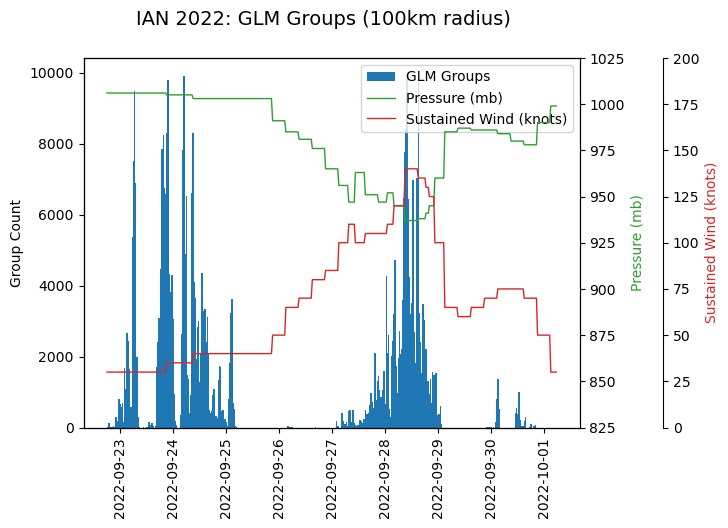

In [41]:
fig, ax = plt.subplots()

fig.suptitle(f"{hurricane_name} {hurricane_year}: GLM Groups ({radius}km radius)", fontsize=14)

# Left axis: group count
ax.bar(
    lightning_df['time'],
    lightning_df['groups'],
    width=0.03,          # tune based on time resolution
    color='tab:blue',
    label='GLM Groups'
)
ax.set_ylabel('Group Count')
ax.tick_params(axis='y')
ax.tick_params(axis='x', labelrotation=90)

# Right axis 1: pressure
ax_r1 = ax.twinx()
ax_r1.plot(
    best_track_df['Timestamp'],
    best_track_df['Minimum Pressure'],
    color='tab:green',
    label='Pressure (mb)',
    linewidth=1
)
ax_r1.set_ylim(825, 1025)
ax_r1.set_ylabel('Pressure (mb)', color='tab:green')
ax_r1.tick_params(axis='y')

# Right axis 2: wind speed
ax_r2 = ax.twinx()
ax_r2.plot(
    best_track_df['Timestamp'],
    best_track_df['Maximum Sustained Winds'],
    color='tab:red',
    label='Sustained Wind (knots)',
    linewidth=1
)
ax_r2.set_ylim(0, 200)
ax_r2.set_ylabel('Sustained Wind (knots)', color='tab:red')
ax_r2.tick_params(axis='y')
ax_r2.spines['right'].set_position(('outward', 60))

lines = []
labels = []

for a in [ax, ax_r1, ax_r2]:
    l, lab = a.get_legend_handles_labels()
    lines.extend(l)
    labels.extend(lab)

ax.legend(lines, labels, loc='best')


plt.show()